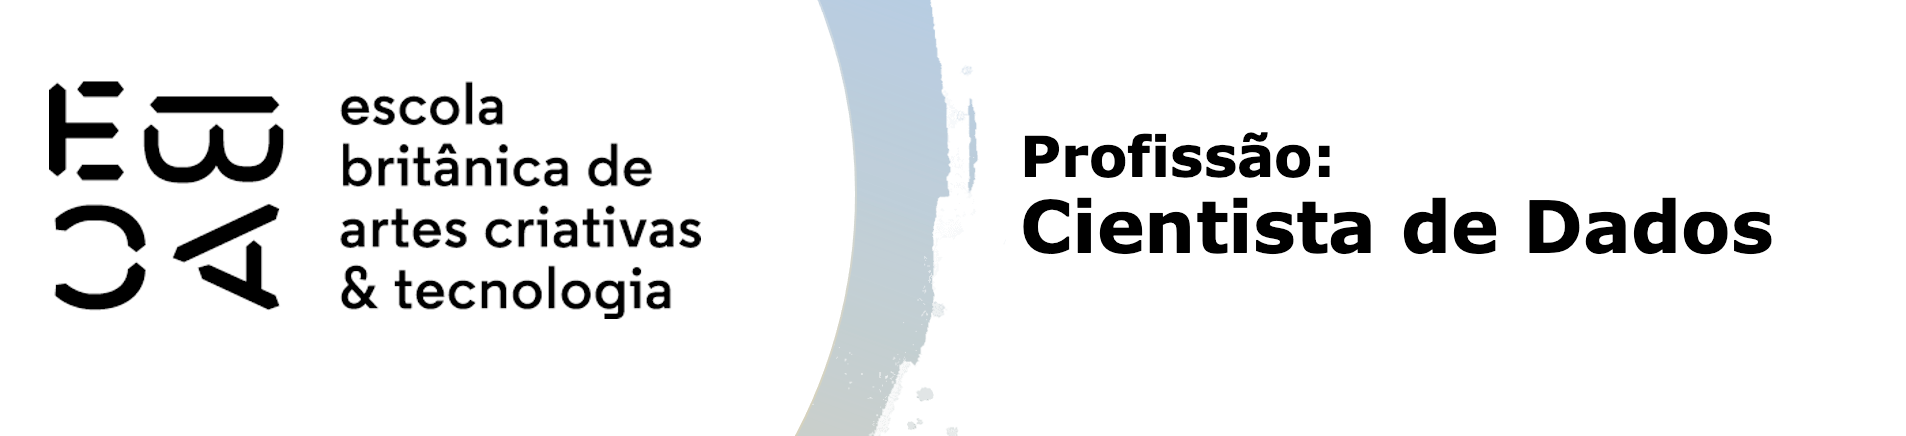

# Pacotes

In [1]:
import numpy  as np
import pandas as pd

from sklearn.pipeline      import Pipeline
from sklearn.impute        import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose       import ColumnTransformer

from sklearn.linear_model      import LogisticRegression
from sklearn.ensemble          import RandomForestClassifier
from sklearn.decomposition     import PCA
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split
from sklearn.metrics         import accuracy_score, roc_auc_score, roc_curve

from sklearn.base import BaseEstimator, TransformerMixin

from pycaret.classification import *

# Tarefa

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [2]:
df = pd.read_feather('dados/credit_scoring.ftr')
df.head()

df_amostra = df.sample(frac=0.2, random_state=27).reset_index(drop=True)
df_amostra.to_feather("dados/amostra.ftr") # um dataframe com tamanho menor para testarmos no strealit com mais rapidez

In [3]:
df.dtypes

data_ref                 datetime64[ns]
index                             int64
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                        int64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                             int64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
mau                                bool
dtype: object

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
df = df.drop(columns='index')

data_maxima = df['data_ref'].max()
data_corte = data_maxima - pd.DateOffset(months=3)

# 2. Criar dois DataFrames:

df_oot = df[df['data_ref'] > data_corte]
df_base = df[df['data_ref'] <= data_corte]

df_oot_pipeline = df[df['data_ref'] > data_corte] # Utilizaremos no futuro
df_base_pipeline = df[df['data_ref'] <= data_corte] # Utilizaremos no futuro


df_oot_pycaret = df[df['data_ref'] > data_corte] # Utilizaremos no futuro
df_base_pycaret = df[df['data_ref'] <= data_corte] # Utilizaremos no futuro

In [5]:
print('\nDF out of time:\n',df_oot['data_ref'].value_counts())
print('\nDF para treino:\n',df_base['data_ref'].value_counts())


DF out of time:
 2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64

DF para treino:
 2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
Name: data_ref, dtype: int64


In [6]:
df_base.columns

Index(['data_ref', 'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'mau'],
      dtype='object')

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

### Nº de Linhas

In [7]:
print('\nNº de linhas para cada data_ref:\n',df_base['data_ref'].value_counts())


Nº de linhas para cada data_ref:
 2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
Name: data_ref, dtype: int64


### Definindo variáveis

In [8]:
variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                          'tipo_renda', 'educacao', 'estado_civil',
                          'tipo_residencia', 'mau']

var_quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

### Variáveis Qualitativas

In [9]:
for coluna in variaveis_qualitativas:
    print('\n',coluna.upper())
    print(df_base[coluna].value_counts())
    print(df_base[coluna].value_counts(normalize=True).apply(lambda x: f'{x:.2%}'))


 SEXO
F    403805
M    196195
Name: sexo, dtype: int64
F    67.30%
M    32.70%
Name: sexo, dtype: object

 POSSE_DE_VEICULO
N    366293
S    233707
Name: posse_de_veiculo, dtype: int64
N    61.05%
S    38.95%
Name: posse_de_veiculo, dtype: object

 POSSE_DE_IMOVEL
S    403054
N    196946
Name: posse_de_imovel, dtype: int64
S    67.18%
N    32.82%
Name: posse_de_imovel, dtype: object

 TIPO_RENDA
Assalariado         308460
Empresário          138141
Pensionista         101127
Servidor público     51981
Bolsista               291
Name: tipo_renda, dtype: int64
Assalariado         51.41%
Empresário          23.02%
Pensionista         16.85%
Servidor público     8.66%
Bolsista             0.05%
Name: tipo_renda, dtype: object

 EDUCACAO
Médio                  405449
Superior completo      163440
Superior incompleto     23559
Fundamental              6901
Pós graduação             651
Name: educacao, dtype: int64
Médio                  67.57%
Superior completo      27.24%
Superior incomple

### Variáveis Quantitativas

In [10]:
df_base[var_quantitativas].describe()


,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,600000.000000,600000.000000,499125.000000,600000.000000,6.000000e+05
mean,0.433210,43.798530,7.747992,2.212122,2.722284e+04
std,0.739869,11.230659,6.688576,0.903757,8.737788e+04
min,0.000000,22.000000,0.117808,1.000000,1.618600e+02
25%,0.000000,34.000000,3.049315,2.000000,4.670600e+03
50%,0.000000,43.000000,6.046575,2.000000,9.887580e+03
75%,1.000000,53.000000,10.180822,3.000000,2.162887e+04
max,14.000000,68.000000,42.906849,15.000000,4.083986e+06


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

### Bivariada Qualitativa

In [11]:
for var in variaveis_qualitativas:
    print('\nVariável:', var.upper())
    print('Contagem:')
    print(pd.crosstab(df_base[var], df_base['mau']))
    print('\nProporção de maus por categoria:')
    print(pd.crosstab(df_base[var], df_base['mau'], normalize='index').round(3) * 100)


Variável: SEXO
Contagem:
mau    False  True 
sexo               
F     378318  25487
M     185039  11156

Proporção de maus por categoria:
mau   False  True 
sexo              
F      93.7    6.3
M      94.3    5.7

Variável: POSSE_DE_VEICULO
Contagem:
mau                False  True 
posse_de_veiculo               
N                 343778  22515
S                 219579  14128

Proporção de maus por categoria:
mau               False  True 
posse_de_veiculo              
N                  93.9    6.1
S                  94.0    6.0

Variável: POSSE_DE_IMOVEL
Contagem:
mau               False  True 
posse_de_imovel               
N                183305  13641
S                380052  23002

Proporção de maus por categoria:
mau              False  True 
posse_de_imovel              
N                 93.1    6.9
S                 94.3    5.7

Variável: TIPO_RENDA
Contagem:
mau                False  True 
tipo_renda                     
Assalariado       288865  19595
Bolsista         

### Bivariada Quantitativa

In [12]:
for var in var_quantitativas:
    print('\nVariável:', var.upper())
    print(df_base.groupby('mau')[var].describe(),'\n\n')


Variável: QTD_FILHOS
          count      mean       std  min  25%  50%  75%   max
mau                                                          
False  563357.0  0.431925  0.738337  0.0  0.0  0.0  1.0  14.0
True    36643.0  0.452965  0.762783  0.0  0.0  0.0  1.0  14.0 



Variável: IDADE
          count       mean        std   min   25%   50%   75%   max
mau                                                                
False  563357.0  43.871059  11.202135  22.0  34.0  43.0  53.0  68.0
True    36643.0  42.683459  11.603637  22.0  33.0  41.0  52.0  68.0 



Variável: TEMPO_EMPREGO
          count      mean       std       min       25%       50%        75%  \
mau                                                                            
False  468960.0  7.948183  6.780904  0.117808  3.183562  6.263014  10.479452   
True    30165.0  4.635732  3.885166  0.117808  1.698630  3.802740   6.504110   

             max  
mau               
False  42.906849  
True   40.786301   



Variável:

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

### Possiveis Zeros Estruturais

In [13]:
print(df_base[df_base['tempo_emprego'] == 0].groupby('tipo_renda')['renda'].describe())
print('\n',df_base[df_base['renda'] == 0].groupby('tipo_renda')['tempo_emprego'].describe())
print('\n',df_base[df_base['idade'] == 0].groupby('tipo_renda')['renda'].describe())

Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: []

 Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: []

 Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: []


### Missing

In [14]:
df_base.isnull().sum()

data_ref                      0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            100875
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [15]:
df_base.loc[:,'tempo_emprego'] = df_base.groupby('tipo_renda')['tempo_emprego'].transform(
    lambda x: x.fillna(x.median())
)

df_base.isnull().sum()

data_ref                 0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

### Outliers

In [16]:
colunas_numericas = df_base.select_dtypes(include='number').columns.tolist()

In [17]:
# Detectar outliers

def detectar_outliers_iqr(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 4 * IQR
    limite_superior = Q3 + 4 * IQR
    outliers = df[(df[coluna] < limite_inferior) | (df[coluna] > limite_superior)]
    return outliers

# Excluir outliers
def remover_outliers_iqr(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 4 * IQR
    limite_superior = Q3 + 4 * IQR
    df_filtrado = df[(df[coluna] >= limite_inferior) & (df[coluna] <= limite_superior)]
    return df_filtrado


In [18]:
for col in colunas_numericas:
    outliers = detectar_outliers_iqr(df_base, col)
    print(f'{col}: {len(outliers)} outliers ({100 * len(outliers) / len(df_base):.2f}%)')
    
print('\nShape do dataframe: ',df_base.shape)

qtd_filhos: 153 outliers (0.03%)
idade: 0 outliers (0.00%)
tempo_emprego: 5818 outliers (0.97%)
qt_pessoas_residencia: 153 outliers (0.03%)
renda: 30086 outliers (5.01%)

Shape do dataframe:  (600000, 14)


In [19]:
for col in colunas_numericas:
    df_base = remover_outliers_iqr(df_base, col)

print('Novo shape do dataframe: ',df_base.shape)

Novo shape do dataframe:  (567956, 14)


### Agrupamentos

In [20]:
print(df_base.groupby('tipo_renda')['mau'].mean().sort_values())

tipo_renda
Bolsista            0.044118
Servidor público    0.051084
Empresário          0.062297
Pensionista         0.064405
Assalariado         0.067336
Name: mau, dtype: float64


In [21]:
df_base['tipo_renda_agrupado'] = df_base['tipo_renda'].replace({
    'Bolsista': 'Informal',
    'Servidor público': 'Estável',
    'Empresário': 'Variável',
    'Pensionista': 'Estável',
    'Assalariado': 'Formal',
})

df_base['tipo_renda_agrupado'].value_counts()

Formal      289935
Estável     146281
Variável    131468
Informal       272
Name: tipo_renda_agrupado, dtype: int64

## Predição para MAU (Logistica)

In [22]:
# Dummies para variáveis categóricas
X = pd.get_dummies(df_base.drop(columns=['mau', 'data_ref']), drop_first=True)
y = df_base['mau']

# Separando dados em desenvolvimento (treino) e out-of-time (últimos 3 meses)
df_base['data_ref'] = pd.to_datetime(df_base['data_ref'])

# Cortando os últimos 3 meses
data_corte = df_base['data_ref'].max() - pd.DateOffset(months=3)
df_desenvolvimento = df_base[df_base['data_ref'] < data_corte]
df_out_time = df_base[df_base['data_ref'] >= data_corte]

X_dev = pd.get_dummies(df_desenvolvimento.drop(columns=['mau', 'data_ref']), drop_first=True)
y_dev = df_desenvolvimento['mau']

X_out = pd.get_dummies(df_out_time.drop(columns=['mau', 'data_ref']), drop_first=True)
y_out = df_out_time['mau']

# Garantir que as colunas estão alinhadas
X_out = X_out.reindex(columns=X_dev.columns, fill_value=0)

In [23]:
%%time
modelo = LogisticRegression(max_iter=700)
modelo.fit(X_dev, y_dev)

CPU times: total: 1min 20s
Wall time: 33.9 s


LogisticRegression(max_iter=700)

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [24]:
def ks_gini(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    ks = max(tpr - fpr)
    auc = roc_auc_score(y_true, y_prob)
    gini = 2 * auc - 1
    return ks, gini, auc

y_dev_pred_prob = modelo.predict_proba(X_dev)[:,1]
y_dev_pred = modelo.predict(X_dev)

acc_dev = accuracy_score(y_dev, y_dev_pred)
ks_dev, gini_dev, auc_dev = ks_gini(y_dev, y_dev_pred_prob)


y_out_pred_prob = modelo.predict_proba(X_out)[:,1]
y_out_pred = modelo.predict(X_out)

acc_out = accuracy_score(y_out, y_out_pred)
ks_out, gini_out, auc_out = ks_gini(y_out, y_out_pred_prob)

In [25]:
print("Desenvolvimento:")
print(f"Acurácia: {acc_dev:.4f}")
print(f"KS: {ks_dev:.4f}")
print(f"Gini: {gini_dev:.4f}")
print(f"AUC: {auc_dev:.4f}\n")

print("Out-of-Time:")
print(f"Acurácia: {acc_out:.4f}")
print(f"KS: {ks_out:.4f}")
print(f"Gini: {gini_out:.4f}")
print(f"AUC: {auc_out:.4f}")

Desenvolvimento:
Acurácia: 0.9377
KS: 0.3911
Gini: 0.5226
AUC: 0.7613

Out-of-Time:
Acurácia: 0.9317
KS: 0.3549
Gini: 0.4820
AUC: 0.7410


# 1 - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [26]:
class PreencherTempoEmprego(BaseEstimator, TransformerMixin):
    def __init__(self, grupo='tipo_renda', coluna='tempo_emprego'):
        self.grupo = grupo
        self.coluna = coluna
        self.medianas_ = {}

    def fit(self, X, y=None):
        self.medianas_ = X.groupby(self.grupo)[self.coluna].median().to_dict()
        return self

    def transform(self, X):
        X = X.copy()
        mask = X[self.coluna].isna()
        for grupo_valor, mediana in self.medianas_.items():
            cond = (X[self.grupo] == grupo_valor) & mask
            X.loc[cond, self.coluna] = mediana
        return X

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [27]:
class RemoverOutliersIQR(BaseEstimator, TransformerMixin):
    def __init__(self, colunas):
        self.colunas = colunas
    
    def fit(self, X, y=None):
        self.limits = {}
        for col in self.colunas:
            q1 = X[col].quantile(0.25)
            q3 = X[col].quantile(0.75)
            iqr = q3 - q1
            self.limits[col] = (q1 - 4 * iqr, q3 + 4 * iqr)
        return self

    def transform(self, X):
        X = X.copy()
        for col, (lower, upper) in self.limits.items():
            X = X[(X[col] >= lower) & (X[col] <= upper)]
        return X


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [28]:
%%time
selecao = SelectFromModel(RandomForestClassifier(n_estimators=500, random_state=27), threshold='median')

CPU times: total: 0 ns
Wall time: 0 ns


### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [29]:
pca = PCA(n_components=0.95)  # mantém 95% da variância

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [30]:
colunas_categoricas = [
    'sexo', 'posse_de_veiculo', 'posse_de_imovel', 
    'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'
]

colunas_numericas = df_base_pipeline.select_dtypes(include=['int64', 'float64','bool']).drop(columns='mau').columns.tolist()

pipeline_numerico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

pipeline_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', pipeline_numerico, colunas_numericas),
    ('cat', pipeline_categorico, colunas_categoricas)
])

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [31]:
pipeline_final = Pipeline(steps=[
    ('preencher_missings', PreencherTempoEmprego()),
    ('remover_outliers', RemoverOutliersIQR(colunas=colunas_numericas)),
    ('preprocessamento', preprocessor),
    ('selecao_variaveis', selecao), 
    ('pca', PCA(n_components=0.95)),
    ('classificador', LogisticRegression())
])


In [32]:
pipeline_final

Pipeline(steps=[('preencher_missings', PreencherTempoEmprego()),
                ('remover_outliers',
                 RemoverOutliersIQR(colunas=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia',
                                             'renda'])),
                ('preprocessamento',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['qtd_filhos', 'idade',
                                                   'tempo_emprego',
                                                   'qt_pes...
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sexo', 'posse_de_veiculo',
                                                   'posse_de_imovel',
                                                   'tipo_renda', 'educacao',
                                                   'estado_civil',
                                                   'tipo_residencia'])])),
                ('selecao_variaveis',
                 SelectFromModel(estimator=RandomForestClassifier(n_estimators=500,
                                                                  random_state=27),
                                 threshold='median')),
                ('pca', PCA(n_components=0.95)),
                ('classificador', LogisticRegression())])

# 2 - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [33]:
def agrupar_categorias_raras(df, coluna, threshold=0.05):
    freq = df[coluna].value_counts(normalize=True)
    categorias_raras = freq[freq < threshold].index
    df[coluna] = df[coluna].replace(categorias_raras, 'outros')
    return df

for col in ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']:
    df_base_pycaret = agrupar_categorias_raras(df_base_pycaret, col, threshold=0.05)


exp = setup(
    data=df_base_pycaret,
    target='mau',
    train_size=0.8,
    session_id=123,
    categorical_features=[
        'sexo', 'posse_de_veiculo', 'posse_de_imovel', 
        'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'
    ],
    numeric_features=[col for col in df_base_pycaret.select_dtypes(include=['int64', 'float64', 'bool']).columns if col != 'mau'],
    normalize=True,
    transformation=False,
    imputation_type='simple',
    remove_outliers=True,
    outliers_threshold=0.05,
    ignore_features=['data_ref'],
    fix_imbalance=True,
    fix_imbalance_method='smote'
)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(600000, 14)"
4,Transformed data shape,"(975712, 23)"
5,Transformed train set shape,"(855712, 23)"
6,Transformed test set shape,"(120000, 23)"
7,Ignore features,1
8,Numeric features,5
9,Categorical features,7


In [34]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.9389,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,3.6280
xgboost,Extreme Gradient Boosting,0.9254,0.7620,0.1444,0.2832,0.1912,0.1564,0.1663,36.5210
lightgbm,Light Gradient Boosting Machine,0.9236,0.7671,0.1714,0.2887,0.2150,0.1776,0.1843,6.2310
gbc,Gradient Boosting Classifier,0.9155,0.7625,0.2188,0.2664,0.2402,0.1960,0.1970,50.7150
rf,Random Forest Classifier,0.9107,0.6384,0.1187,0.1697,0.1397,0.0941,0.0958,34.9950
dt,Decision Tree Classifier,0.9098,0.5905,0.1153,0.1632,0.1351,0.0891,0.0906,5.2990
ada,Ada Boost Classifier,0.9083,0.7488,0.2512,0.2502,0.2505,0.2017,0.2018,17.5310
knn,K Neighbors Classifier,0.9076,0.6083,0.0912,0.1312,0.1076,0.0606,0.0617,93.5530
et,Extra Trees Classifier,0.9070,0.5915,0.1220,0.1591,0.1380,0.0898,0.0907,62.2810
lr,Logistic Regression,0.5623,0.7592,0.8227,0.1053,0.1867,0.0880,0.1765,7.7280


In [35]:
lightgbm_model = create_model('lightgbm')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9240,0.7732,0.1791,0.2975,0.2236,0.1862,0.1929
1,0.9228,0.7667,0.1754,0.2852,0.2172,0.1790,0.1849
2,0.9237,0.7659,0.1784,0.2945,0.2222,0.1847,0.1911
3,0.9254,0.7716,0.1808,0.3103,0.2285,0.1922,0.1999
4,0.9222,0.7644,0.1590,0.2686,0.1997,0.1617,0.1678
5,0.9226,0.7692,0.1614,0.2737,0.2030,0.1652,0.1716
6,0.9233,0.7696,0.1675,0.2833,0.2105,0.1730,0.1796
7,0.9240,0.7635,0.1685,0.2902,0.2132,0.1762,0.1835
8,0.9251,0.7640,0.1733,0.3022,0.2202,0.1839,0.1918


In [36]:
tuned_lightgbm = tune_model(lightgbm_model)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9262,0.7692,0.1546,0.2982,0.2036,0.1690,0.1791
1,0.9251,0.7612,0.1566,0.2898,0.2033,0.1677,0.1765
2,0.9259,0.7643,0.1600,0.2997,0.2086,0.1735,0.1829
3,0.9269,0.7687,0.1539,0.3051,0.2046,0.1706,0.1817
4,0.9248,0.7608,0.1440,0.2767,0.1894,0.1541,0.1631
5,0.9257,0.7634,0.1440,0.2855,0.1914,0.1569,0.1671
6,0.9257,0.7671,0.1453,0.2863,0.1928,0.1581,0.1682
7,0.9261,0.7588,0.1518,0.2953,0.2005,0.1659,0.1761
8,0.9263,0.7605,0.1487,0.2954,0.1978,0.1636,0.1743


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [37]:
evaluate_model(tuned_lightgbm)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Gráficos com Pycaret

Como pode acontecer do `evaluate_model` causar problemas de compatibilidade e/ou ser lento, fazendo com que os gráficos não apareçam, vou plotar os gráficos mais significativos abaixo.

### Matriz de Confusão

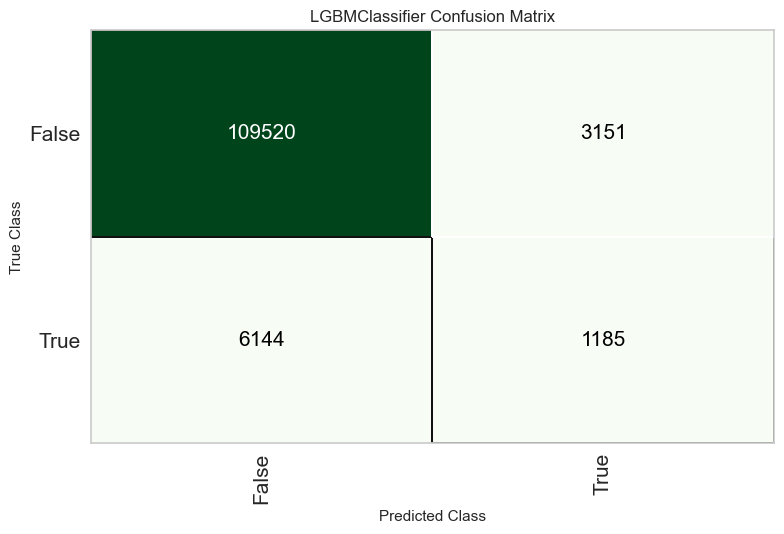

In [44]:
plot_model(tuned_lightgbm, plot='confusion_matrix')

### importância das Variáveis

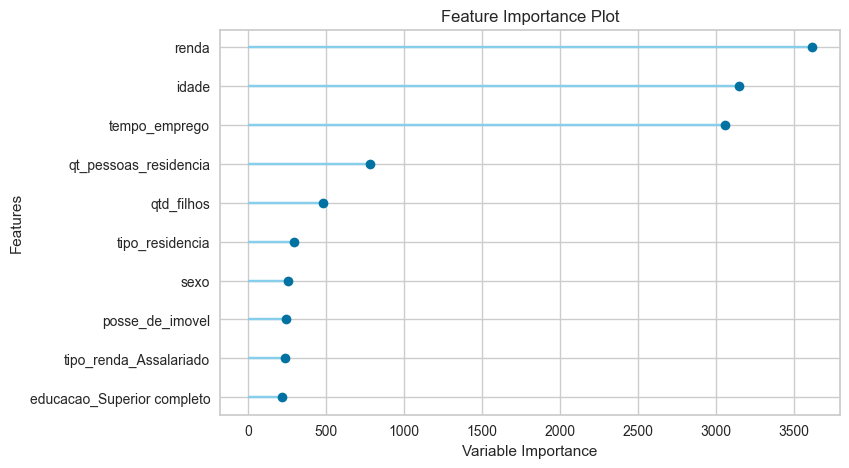

In [45]:
plot_model(tuned_lightgbm, plot='feature')

### Curva AUC-ROC

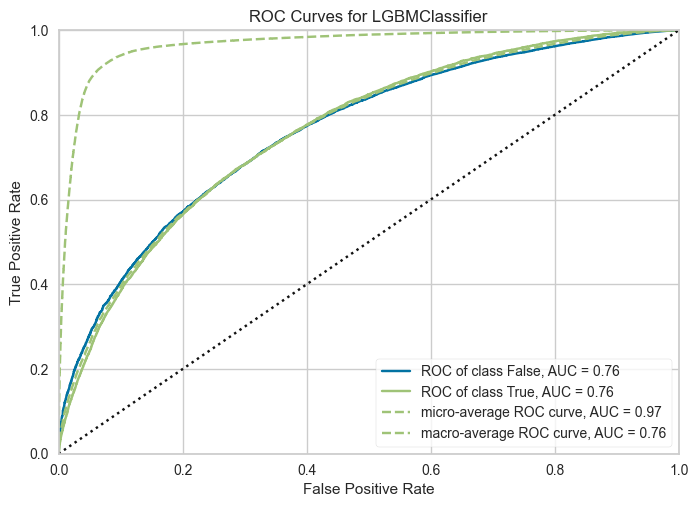

In [46]:
plot_model(tuned_lightgbm, plot='auc')

### Curva Precision-Recall

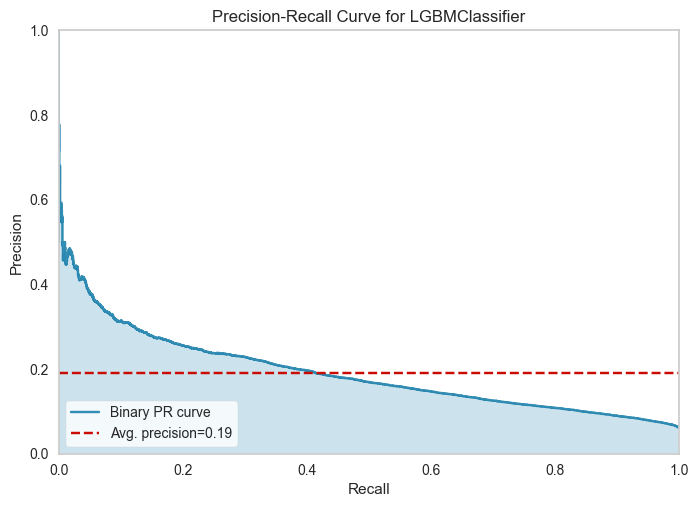

In [47]:
plot_model(tuned_lightgbm, plot='pr')

### Relatório de Classificação

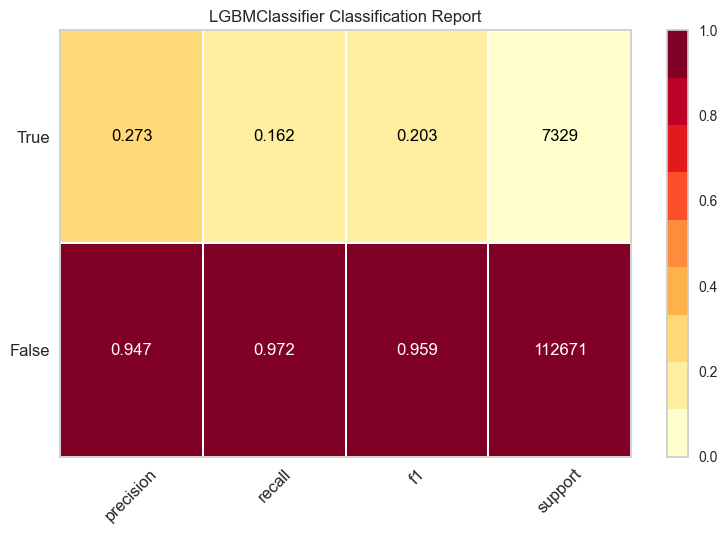

In [48]:
plot_model(tuned_lightgbm, plot='class_report')

## Salvando o Modelo

In [38]:
save_model(tuned_lightgbm, 'dados/modelo_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            